In [21]:
!pip install langdetect nltk scikit-learn gensim openpyxl

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases, Phraser

# إعدادات الرسومات
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 18)
plt.rcParams['font.size'] = 12

# تحميل ملفات NLTK الضرورية
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
file_path = '/content/Linkedin Job Posts in Saudi Arabia 2020.xlsx'

try:
    df = pd.read_excel(file_path)
    print(" تم تحميل الملف بنجاح! عدد الصفوف:", len(df))
except FileNotFoundError:
    print(" الملف غير موجود. تأكد من رفع الملف وتحديث المسار.")

 تم تحميل الملف بنجاح! عدد الصفوف: 48449


In [23]:
if not df.empty:
    print("\n--- [1] New Feature Engineering (Dates, Locations, Exp) ---")

    # A. معالجة التاريخ
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        print("-> Dates processed.")

    # B. تنظيف المدن وإنشاء المناطق (Regions) - (تم إصلاح الخطأ هنا)
    def clean_city(location):
        if pd.isna(location): return "Unknown"
        loc = str(location).lower()
        # إبقاء الحروف والأرقام والمسافات فقط
        loc = re.sub(r'[^\w\s]', '', loc)

        corrections = {
            'riyadh': 'Riyadh', 'jeddah': 'Jeddah', 'dammam': 'Dammam',
            'khobar': 'Khobar', 'makkah': 'Makkah', 'medina': 'Madinah',
            'madinah': 'Madinah', 'yanbu': 'Yanbu', 'jubail': 'Jubail',
            'dhahran': 'Dhahran', 'jazan': 'Jizan', 'jizan': 'Jizan',
            'tabuk': 'Tabuk', 'hail': 'Hail', 'abha': 'Abha',
            'taif': 'Taif', 'buraydah': 'Buraydah', 'unaizah': 'Unaizah',
            'remote': 'Remote'
        }
        for key, val in corrections.items():
            if key in loc: return val

        # [FIX] التحقق من أن النص ليس فارغاً قبل التقسيم
        parts = loc.split()
        if parts:
            return parts[0].title()
        return "Unknown"

    df['city_cleaned'] = df['location'].apply(clean_city)

    def get_region(city):
        city = str(city)
        regions_map = {
            'Central': ['Riyadh', 'Kharj', 'Diriyah', 'Zulfi', 'Shaqra'],
            'Western': ['Jeddah', 'Makkah', 'Madinah', 'Taif', 'Yanbu', 'Rabigh'],
            'Eastern': ['Dammam', 'Khobar', 'Jubail', 'Dhahran', 'Hofuf', 'Ahsa', 'Qatif'],
            'Southern': ['Abha', 'Jizan', 'Najran', 'Khamis', 'Bisha'],
            'Northern': ['Tabuk', 'Hail', 'Arar', 'Sakaka', 'Jawf'],
            'Qassim': ['Qassim', 'Buraydah', 'Unaizah', 'Rass']
        }
        for region, cities in regions_map.items():
            if any(c in city for c in cities):
                return region
        return 'Other'

    df['Region'] = df['city_cleaned'].apply(get_region)
    print("-> Regions created.")

    # C. استخراج سنوات الخبرة والمؤهل (Regex Extraction)
    def extract_experience(text):
        if pd.isna(text): return np.nan
        text = str(text).lower()
        match = re.search(r'(\d+)\s*(\+|to|-)?\s*(\d+)?\s*(years|year|yrs)', text)
        if match:
            return int(match.group(1))
        return np.nan

    def extract_degree(text):
        if pd.isna(text): return "Not Specified"
        text = str(text).lower()
        if any(w in text for w in ['phd', 'doctorate']): return 'PhD'
        if any(w in text for w in ['master', 'msc', 'mba']): return 'Master'
        if any(w in text for w in ['bachelor', 'bsc', 'bs', 'degree', 'university']): return 'Bachelor'
        if any(w in text for w in ['diploma']): return 'Diploma'
        return "Not Specified"

    df['Years_Experience'] = df['description'].apply(extract_experience)
    if 'level' in df.columns:
        df['Years_Experience'] = df['Years_Experience'].fillna(df.groupby('level')['Years_Experience'].transform('mean'))

    df['Education_Level'] = df['description'].apply(extract_degree)
    print("-> Experience & Education extracted.")


--- [1] New Feature Engineering (Dates, Locations, Exp) ---
-> Dates processed.
-> Regions created.
-> Experience & Education extracted.


In [24]:
if not df.empty:
    print("\n--- [2] Applying Abdulaziz's NLP Pipeline ---")

    lemmatizer = WordNetLemmatizer()

    # 1. التنظيف الأساسي والـ Lemmatization
    def basic_clean_text(text):
        if pd.isna(text): return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['clean_text'] = df['description'].apply(basic_clean_text)
    print("-> Basic cleaning & Lemmatization done.")

    # 2. تطبيق Bigrams (العبارات المتلازمة)
    sent = [row.split() for row in df['clean_text']]
    phrases = Phrases(sent, min_count=30, progress_per=10000)
    bigram = Phraser(phrases)
    df['text_phrased'] = df['clean_text'].apply(lambda x: ' '.join(bigram[x.split()]))
    print("-> Bigrams applied.")

    # 3. حذف Stopwords الخاصة (Domain Specific)
    stop_words = set(stopwords.words('english'))
    domain_stopwords = [
        'job', 'work', 'company', 'candidate', 'role', 'opportunity', 'team',
        'apply', 'description', 'requirements', 'responsibilities', 'duties',
        'please', 'click', 'link', 'position', 'looking', 'must', 'skills',
        'experience', 'working', 'business', 'knowledge', 'year', 'years'
    ]
    stop_words.update(domain_stopwords)

    def remove_custom_stops(text):
        return ' '.join([w for w in text.split() if w not in stop_words])

    df['text_no_stops'] = df['text_phrased'].apply(remove_custom_stops)
    print("-> Custom Stopwords removed.")

    # 4. Pruning (حذف الكلمات النادرة جداً والشائعة جداً)
    print("-> Pruning rare words (CountVectorizer)...")
    vectorizer = CountVectorizer(min_df=5, max_df=0.95)
    vectorizer.fit(df['text_no_stops'])
    good_vocabulary = set(vectorizer.get_feature_names_out())

    def prune_text(text):
        return ' '.join([w for w in text.split() if w in good_vocabulary])

    df['final_clean_text'] = df['text_no_stops'].apply(prune_text)
    print("-> Text Pruning done.")

    # 5. استخراج المهارات (Skills Extraction)
    print("-> Extracting Skills & Standardizing Titles...")
    skills_keywords = {
        'python': 'Python', 'java': 'Java', 'c++': 'C++', 'sql': 'SQL',
        'javascript': 'JavaScript', 'html': 'HTML', 'css': 'CSS', 'php': 'PHP',
        'machine_learning': 'Machine Learning', 'deep_learning': 'Deep Learning',
        'data_analysis': 'Data Analysis', 'big_data': 'Big Data', 'statistics': 'Statistics',
        'tensorflow': 'TensorFlow', 'scikit_learn': 'Scikit-learn',
        'excel': 'Excel', 'tableau': 'Tableau', 'power_bi': 'Power BI',
        'oracle': 'Oracle', 'sap': 'SAP', 'salesforce': 'Salesforce',
        'project_management': 'Project Management', 'pmp': 'PMP', 'agile': 'Agile',
        'communication': 'Communication', 'leadership': 'Leadership',
        'teamwork': 'Teamwork', 'problem_solving': 'Problem Solving',
        'marketing': 'Marketing', 'sales': 'Sales',
        'arabic': 'Arabic', 'english': 'English'
    }

    for key, label in skills_keywords.items():
        # استخدام regex boundary لضمان الكلمة كاملة
        df[f'has_{key}'] = df['final_clean_text'].str.contains(rf'\b{key}\b', case=False, regex=True).astype(int)

    # 6. توحيد المسميات الوظيفية (Standardize Titles)
    def standardize_title(title):
        t = str(title).lower()
        if 'manager' in t or 'director' in t or 'head' in t: return 'Manager/Lead'
        elif 'engineer' in t: return 'Engineer'
        elif 'analyst' in t: return 'Analyst'
        elif 'accountant' in t: return 'Accountant'
        elif 'sales' in t or 'representative' in t: return 'Sales'
        elif 'hr' in t or 'human resources' in t: return 'HR'
        else: return 'Other'

    df['std_job_title'] = df['position'].apply(standardize_title)
    print("-> Skills extracted & Titles standardized.")


--- [2] Applying Abdulaziz's NLP Pipeline ---
-> Basic cleaning & Lemmatization done.
-> Bigrams applied.
-> Custom Stopwords removed.
-> Pruning rare words (CountVectorizer)...
-> Text Pruning done.
-> Extracting Skills & Standardizing Titles...
-> Skills extracted & Titles standardized.


In [25]:
if not df.empty:
    # تحديد الأعمدة النهائية التي تهمك
    final_cols = [
        'position', 'company', 'location', 'date', # الأصلية
        'city_cleaned', 'Region', 'Years_Experience', 'Education_Level', # الجديدة من الملف الآخر
        'std_job_title', 'final_clean_text' # من كود عبدالعزيز
    ] + [col for col in df.columns if 'has_' in col] # أعمدة المهارات

    final_df = df[final_cols]

    print("\n تمت العملية بنجاح!")
    print("الأعمدة التي تمت إضافتها تشمل:")
    print("1. المناطق والمدن (Region, city_cleaned)")
    print("2. الخبرة والمؤهل (Years_Experience, Education_Level)")
    print("3. النص المنظف (final_clean_text)")
    print("4. المهارات (has_python, has_sql, etc...)")

    display(final_df.head())


 تمت العملية بنجاح!
الأعمدة التي تمت إضافتها تشمل:
1. المناطق والمدن (Region, city_cleaned)
2. الخبرة والمؤهل (Years_Experience, Education_Level)
3. النص المنظف (final_clean_text)
4. المهارات (has_python, has_sql, etc...)


,position,company,location,date,city_cleaned,Region,Years_Experience,Education_Level,std_job_title,final_clean_text,...,has_pmp,has_agile,has_communication,has_leadership,has_teamwork,has_problem_solving,has_marketing,has_sales,has_arabic,has_english
0,Head of Branding Governance Unit,Riyad Bank,"Riyadh, Saudi Arabia",2020-01-06,Riyadh,Central,8.097919,Not Specified,Manager/Lead,,...,0,0,0,0,0,0,0,0,0,0
1,Document Controller,"Confidential,Confidential","Riyadh, Saudi Arabia",2020-01-06,Riyadh,Central,3.000000,Bachelor,Other,document_controller saudi industry semi_govern...,...,0,0,1,0,0,0,0,0,0,0
2,Employee Engagement Specialist,PepsiCo,"Riyadh, Saudi Arabia",2020-01-06,Riyadh,Central,1.000000,Bachelor,Other,auto_req id_brjob descriptionpepsico_saudi sna...,...,0,0,1,0,0,0,0,0,0,0
3,Strategic Workforce Analyst,Saudi Air Navigation Services,"Jeddah, Saudi Arabia",2020-01-06,Jeddah,Western,8.097919,Bachelor,Analyst,purposeto conduct workforce analysis support s...,...,0,0,0,0,0,0,0,0,0,0
4,"Account Manager, GPS – Riyadh",EY,"Riyadh, Saudi Arabia",2020-01-06,Riyadh,Central,7.000000,Bachelor,Manager/Lead,people product asset inspiring_excellence enga...,...,0,0,0,0,0,0,0,0,0,0



--- [3] Creating Dashboard ---


/tmp/ipython-input-3393255138.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, ax=axes[0, 0], palette='Blues_r')
/tmp/ipython-input-3393255138.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exp_counts.index, y=exp_counts.values, ax=axes[1, 0], palette='viridis')
/tmp/ipython-input-3393255138.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title_counts.index, y=title_counts.values, ax=axes[2, 0], palette='coolwarm')


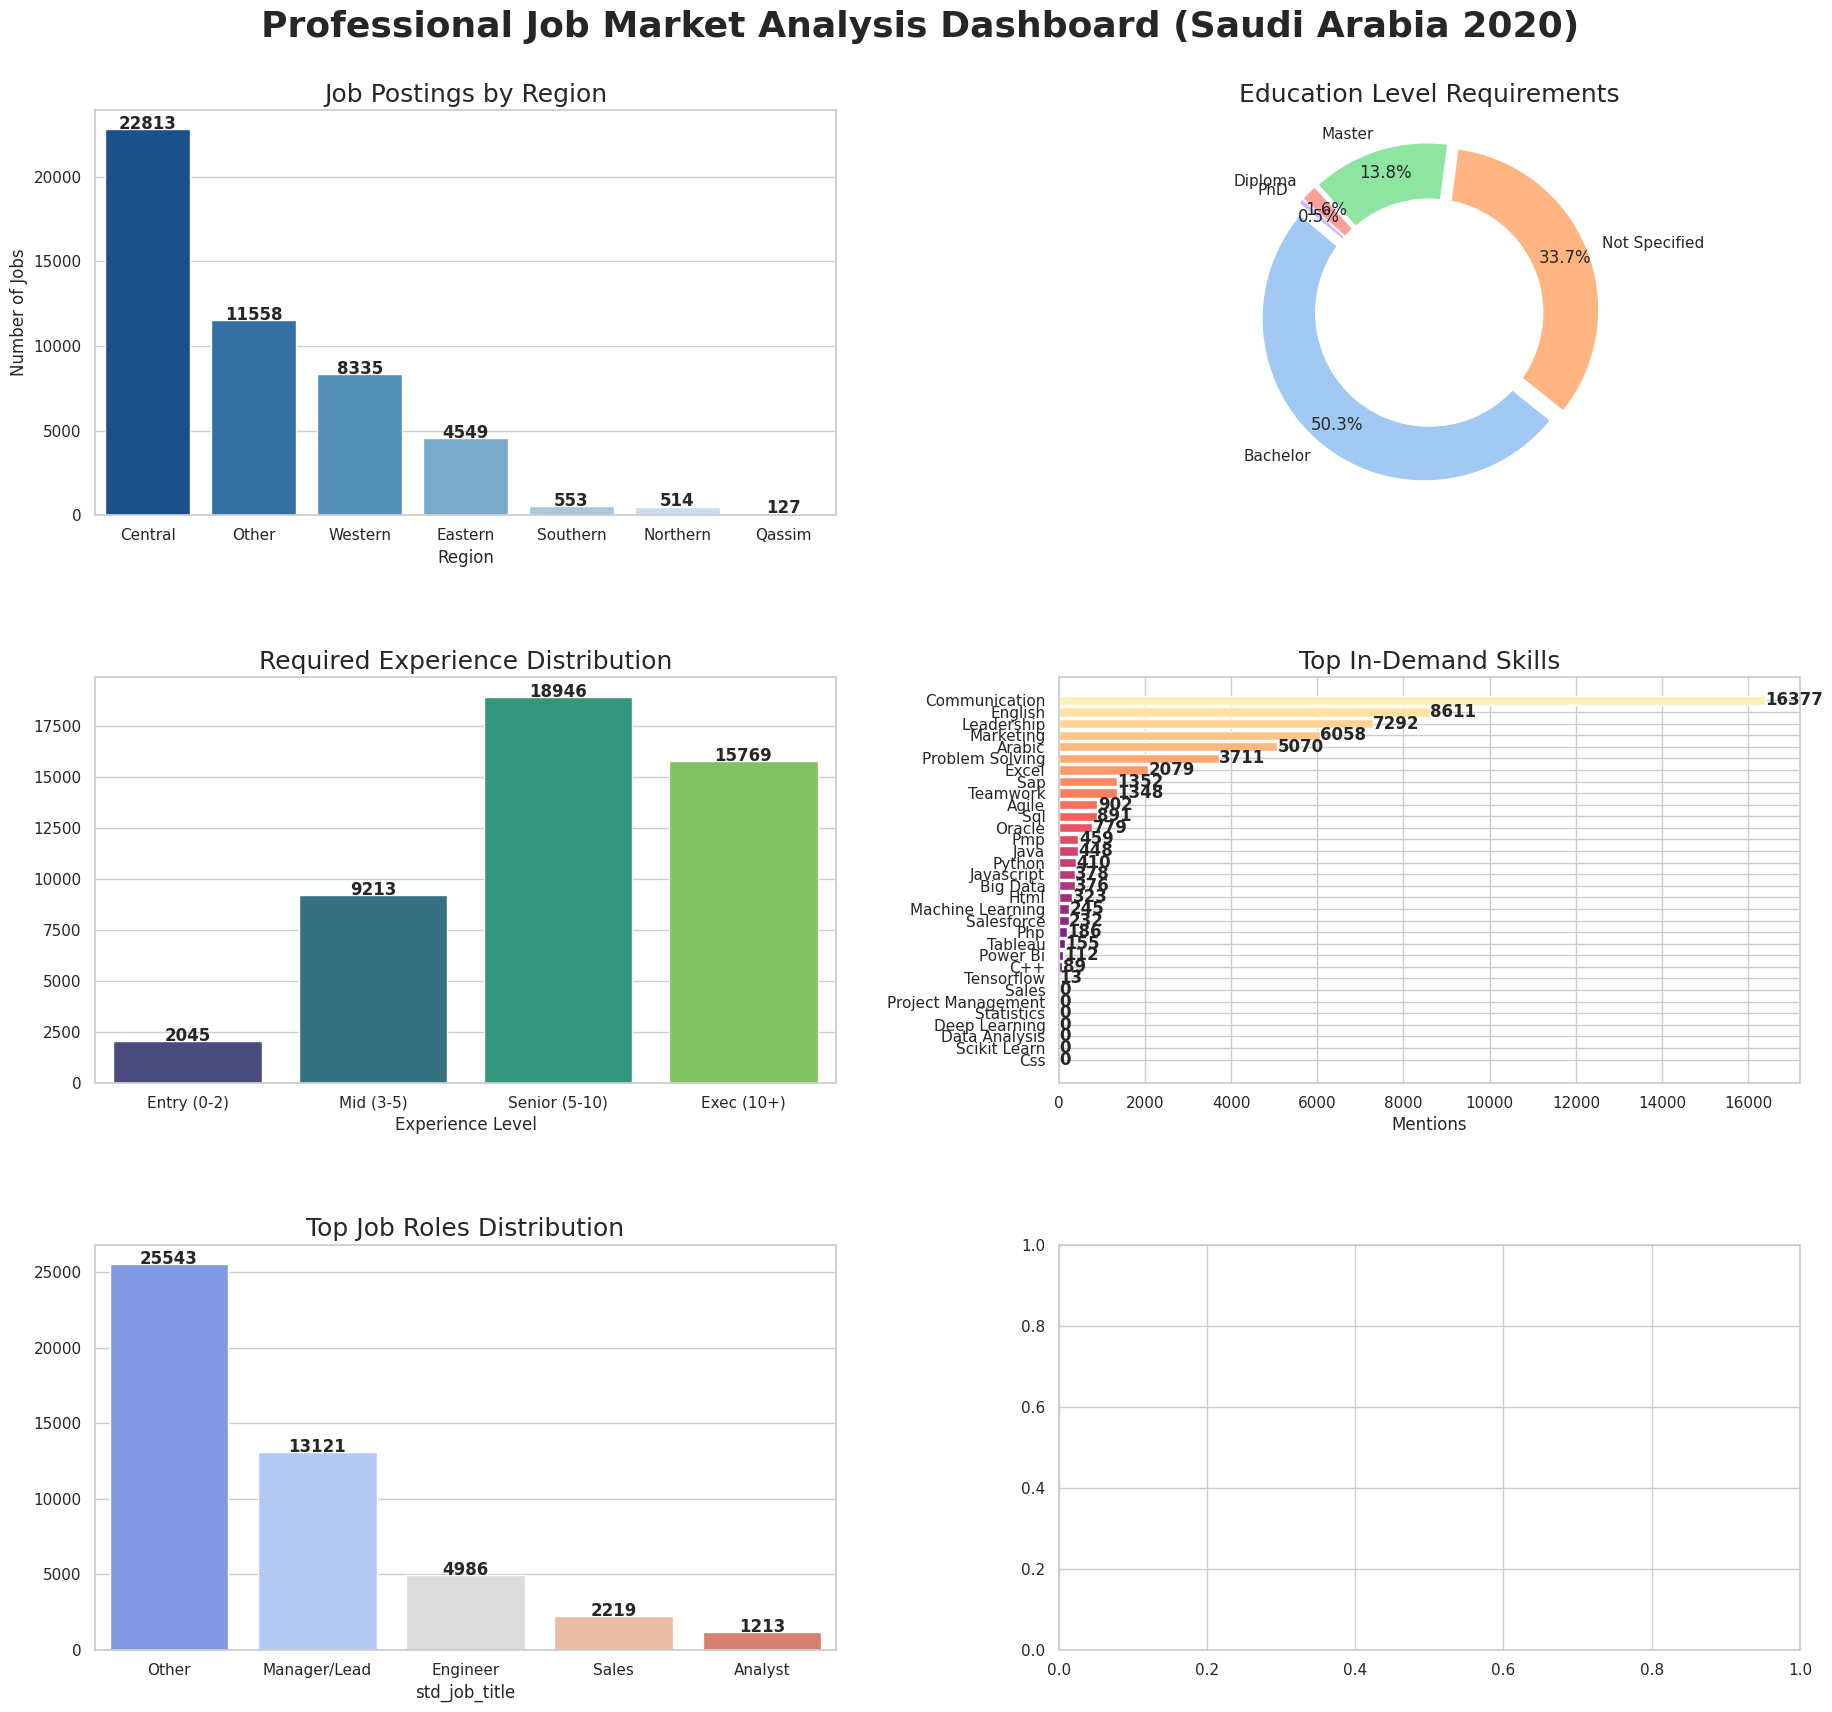

 Dashboard Generated Successfully.


In [26]:
print("\n--- [3] Creating Dashboard ---")

if not df.empty:
    # إعداد الشكل العام (3 صفوف، عمودين)
    fig, axes = plt.subplots(3, 2, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle('Professional Job Market Analysis Dashboard (Saudi Arabia 2020)', fontsize=26, fontweight='bold', y=0.93)

    # 1. الوظائف حسب المنطقة (Bar Chart)
    region_counts = df['Region'].value_counts()
    sns.barplot(x=region_counts.index, y=region_counts.values, ax=axes[0, 0], palette='Blues_r')
    axes[0, 0].set_title('Job Postings by Region', fontsize=18)
    axes[0, 0].set_ylabel('Number of Jobs')
    for i, v in enumerate(region_counts.values):
        axes[0, 0].text(i, v + 10, str(v), ha='center', fontweight='bold')

    # 2. المتطلبات التعليمية (Donut Chart)
    edu_counts = df['Education_Level'].value_counts()
    axes[0, 1].pie(edu_counts, labels=edu_counts.index, autopct='%1.1f%%', startangle=140,
                   colors=sns.color_palette('pastel'), pctdistance=0.85, explode=[0.05]*len(edu_counts))
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    axes[0, 1].add_artist(centre_circle)
    axes[0, 1].set_title('Education Level Requirements', fontsize=18)

    # 3. توزيع سنوات الخبرة (Bar Chart - Binned)
    bins = [0, 2, 5, 10, 50]
    labels = ['Entry (0-2)', 'Mid (3-5)', 'Senior (5-10)', 'Exec (10+)']
    # Use cut directly for plotting
    exp_groups = pd.cut(df['Years_Experience'], bins=bins, labels=labels, right=False)
    exp_counts = exp_groups.value_counts().sort_index()

    sns.barplot(x=exp_counts.index, y=exp_counts.values, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Required Experience Distribution', fontsize=18)
    axes[1, 0].set_xlabel('Experience Level')
    for i, v in enumerate(exp_counts.values):
        axes[1, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

    # 4. المهارات الأكثر طلباً (Horizontal Bar)
    skill_cols = [c for c in df.columns if 'has_' in c]
    skill_sums = df[skill_cols].sum().sort_values(ascending=True)
    skill_names = [s.replace('has_', '').replace('_', ' ').title() for s in skill_sums.index]

    axes[1, 1].barh(skill_names, skill_sums.values, color=sns.color_palette('magma', len(skill_names)))
    axes[1, 1].set_title('Top In-Demand Skills', fontsize=18)
    axes[1, 1].set_xlabel('Mentions')
    for i, v in enumerate(skill_sums.values):
        axes[1, 1].text(v + 10, i, str(v), va='center', fontweight='bold')

    # 5. المسميات الوظيفية (Bar Chart)
    title_counts = df['std_job_title'].value_counts().head(5)
    sns.barplot(x=title_counts.index, y=title_counts.values, ax=axes[2, 0], palette='coolwarm')
    axes[2, 0].set_title('Top Job Roles Distribution', fontsize=18)
    for i, v in enumerate(title_counts.values):
        axes[2, 0].text(i, v + 10, str(v), ha='center', fontweight='bold')

    # 6. اتجاه التوظيف الشهري (Line Chart)
    if 'month' in df.columns and df['month'].notna().sum() > 5:
        month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        # Reindex to ensure order, fill missing with 0
        trend = df['month'].value_counts().reindex(month_order).fillna(0)
        # Filter only months with data to avoid empty plot lines if data is partial
        trend = trend[trend > 0]

        if not trend.empty:
            sns.lineplot(x=trend.index, y=trend.values, ax=axes[2, 1], marker='o', linewidth=3, color='green')
            axes[2, 1].set_title('Job Posting Trend (2020)', fontsize=18)
            axes[2, 1].set_xticklabels(trend.index, rotation=45)
            axes[2, 1].set_ylabel('Posts')
            axes[2, 1].fill_between(range(len(trend)), trend.values, alpha=0.3, color='green')
    else:
        axes[2, 1].text(0.5, 0.5, 'Insufficient Date Data', ha='center', fontsize=16)
        axes[2, 1].axis('off')

    plt.show()
    print(" Dashboard Generated Successfully.")
else:
    print(" Skipping dashboard generation (No Data).")